In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import networkx as nx
import choix

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm


In [65]:
# round design variables

# design the distribution of expertise for voters
# the approach here is to use the beta-distribution as a way to generate a distribution of expertise,
#  with several parameters mapping to low, medium, and high expertise
# We then draw from this distribution to assign expertise to each voter
expertise2params = {
    'very-low': (1, 6),
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'very-high': (6, 1)
}
simulation_badgeholder_expertise = 'very-high'

# similar to the above, define a distribution of project impact.
impact2params = {
    'low': (1, 4),
    'medium': (2, 2),
    'high': (4, 1)
}
simulation_project_impact = 'high'

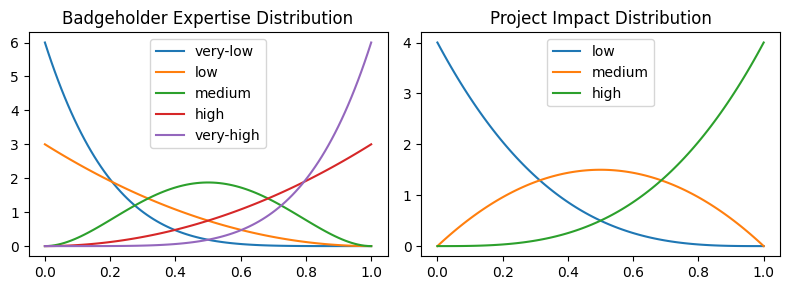

In [66]:
# lets plot the beta distributions pdfs to get a sense of what they look like
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
x = np.linspace(0, 1, 100)

for expertise, params in expertise2params.items():
    pdf = stats.beta.pdf(x, *params)
    ax[0].plot(x, pdf, label=expertise)
ax[0].legend()
ax[0].set_title('Badgeholder Expertise Distribution')

for impact, params in impact2params.items():
    pdf = stats.beta.pdf(x, *params)
    ax[1].plot(x, pdf, label=impact)
ax[1].legend()
ax[1].set_title('Project Impact Distribution')

plt.tight_layout()

Text(0, 0.5, 'Probability of Voting \n for Correct Project (%)')

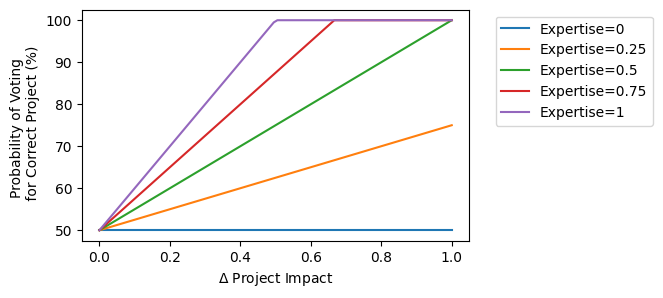

In [55]:
# plot the badgeholder expertise to voting mapping
project_impact_difference_vec = np.linspace(0, 1, 100)
expertise = [0, 0.25, 0.5, 0.75, 1]
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for e in expertise:
    th = 0.5 + project_impact_difference_vec * e
    th = np.clip(th, 0, 1)
    ax.plot(project_impact_difference_vec, th*100, label=f'Expertise={e}')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\Delta$ Project Impact')
ax.set_ylabel('Probability of Voting \n for Correct Project (%)')

In [56]:
# a metric used for comparing the inferred ranking to the actual ranking
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

def run_single_simulation(
        n_badgeholders=50, 
        badgeholder_expertise_distribution='medium',
        badgeholder_voting_style='skewed_towards_impact',
        n_projects=20, 
        project_impact_distribution='low',
        random_seed=1234
    ):
    rng = np.random.default_rng(random_seed)

    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        expertise = rng.beta(*expertise2params[badgeholder_expertise_distribution])
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style=badgeholder_voting_style,
            expertise=expertise
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = rng.beta(*impact2params[project_impact_distribution])
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = itertools.combinations(range(project_population.num_projects), 2)
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the matrix for analysis
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model
    params = choix.ilsr_pairwise(N, vote_data_list)  # can use bayesian approach here
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # compare the inferred ranks to the actual ranks
    actual_project_impacts = np.array([p.true_impact for p in project_list])
    # rank them
    project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # # compare the two
    # print('Actual Project Ranking by impact:', project_ix_worst_to_best_actual)
    # print('Inferred Project Ranking by impact:', project_ix_worst_to_best_inferred)

    min_swaps = min_swaps_to_sort(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
    tau = stats.kendalltau(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred).correlation

    return min_swaps, tau

def run_n_simulations(
    n_sims=100,
    n_badgeholders=50, 
    badgeholder_expertise_distribution='medium',
    badgeholder_voting_style='skewed_towards_impact',
    n_projects=20, 
    project_impact_distribution='low',
    random_seed_start=1234
):
    min_swaps_list = np.zeros(n_sims)
    ktau_list = np.zeros(n_sims)

    # TODO: parallelize
    for ii in tqdm(range(n_sims)):
        seed = random_seed_start + ii
        min_swaps, ktau = run_single_simulation(
            n_badgeholders=n_badgeholders, 
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style=badgeholder_voting_style,
            n_projects=n_projects, 
            project_impact_distribution=project_impact_distribution,
            random_seed=seed
        )
        min_swaps_list[ii] = min_swaps
        ktau_list[ii] = ktau

    return min_swaps_list, ktau_list

In [68]:
min_swaps_vec_vh_med, ktau_vec_vh_med = run_n_simulations(
    n_sims=20,
    n_badgeholders=50, 
    badgeholder_expertise_distribution='very-high',
    badgeholder_voting_style='skewed_towards_impact',
    n_projects=100, 
    project_impact_distribution='medium',
    random_seed_start=1234
)

min_swaps_vec_med_med, ktau_vec_med_med = run_n_simulations(
    n_sims=20,
    n_badgeholders=50, 
    badgeholder_expertise_distribution='medium',
    badgeholder_voting_style='skewed_towards_impact',
    n_projects=100, 
    project_impact_distribution='medium',
    random_seed_start=1234
)

min_swaps_vec_vl_med, ktau_vec_vl_med = run_n_simulations(
    n_sims=20,
    n_badgeholders=50, 
    badgeholder_expertise_distribution='very-low',
    badgeholder_voting_style='skewed_towards_impact',
    n_projects=100, 
    project_impact_distribution='medium',
    random_seed_start=1234
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

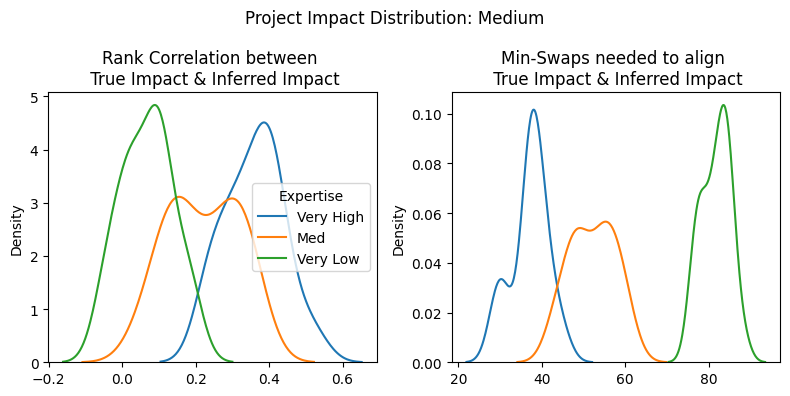

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(ktau_vec_vh_med, ax=ax[0], label='Very High')
sns.kdeplot(ktau_vec_med_med, ax=ax[0], label='Med')
sns.kdeplot(ktau_vec_vl_med, ax=ax[0], label='Very Low')
ax[0].set_title('Rank Correlation between \n True Impact & Inferred Impact')
ax[0].legend(title='Expertise')

sns.kdeplot(min_swaps_vec_vh_med, ax=ax[1], label='Very High')
sns.kdeplot(min_swaps_vec_med_med, ax=ax[1], label='Med')
sns.kdeplot(min_swaps_vec_vl_med, ax=ax[1], label='Very Low')
ax[1].set_title('Min-Swaps needed to align \n True Impact & Inferred Impact')
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
# fig.legend(loc='outside upper center')
plt.suptitle('Project Impact Distribution: Medium')
plt.tight_layout()